In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/lality/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/lality/.fastai/data/camvid/images'),
 PosixPath('/home/lality/.fastai/data/camvid/labels'),
 PosixPath('/home/lality/.fastai/data/camvid/codes.txt')]

In [3]:
path_img = path / 'images'
path_lbl = path / 'labels'

In [4]:
fnames = get_image_files(path_img); fnames[:3]

[PosixPath('/home/lality/.fastai/data/camvid/images/0006R0_f01020.png'),
 PosixPath('/home/lality/.fastai/data/camvid/images/0016E5_06390.png'),
 PosixPath('/home/lality/.fastai/data/camvid/images/Seq05VD_f01830.png')]

In [5]:
lbl_names = get_files(path_lbl); lbl_names[:3]

[PosixPath('/home/lality/.fastai/data/camvid/labels/0006R0_f02340_P.png'),
 PosixPath('/home/lality/.fastai/data/camvid/labels/0016E5_01230_P.png'),
 PosixPath('/home/lality/.fastai/data/camvid/labels/0001TP_009150_P.png')]

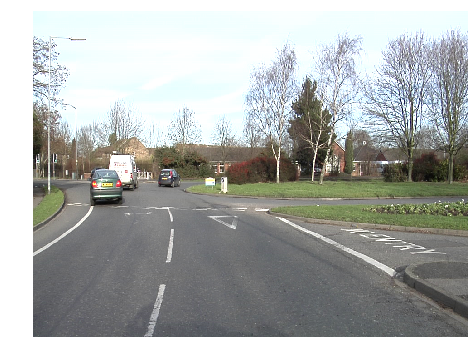

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(8, 6))

In [7]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

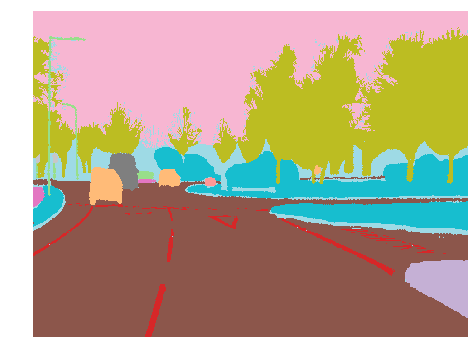

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(8, 6), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str);
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [19]:
size = src_size // 2

free = gpu_mem_get_free_no_cache()
if free > 8200:
    bs = 8
else:
    bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [23]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs).normalize(imagenet_stats))

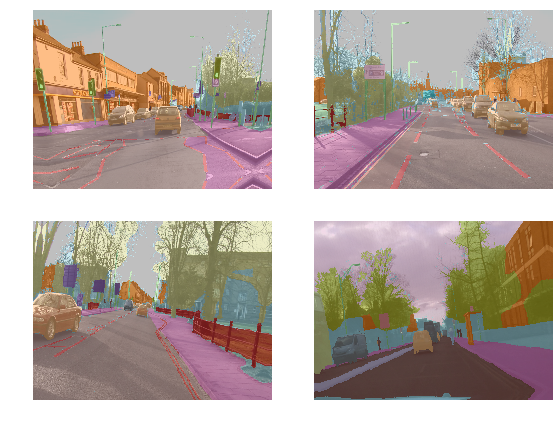

In [24]:
data.show_batch(3, figsize=(8, 6))

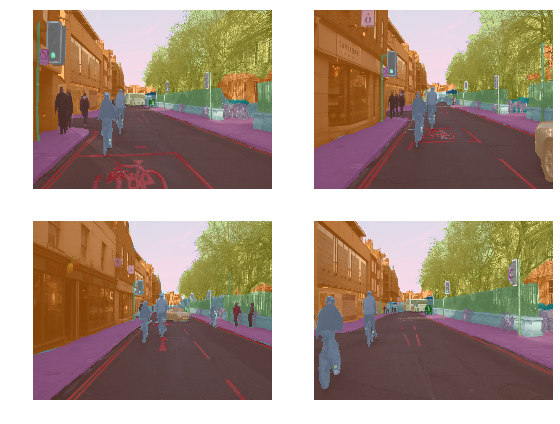

In [25]:
data.show_batch(3, figsize=(8, 6), ds_type=DatasetType.Valid)

In [18]:
name2id = {v: k for k, v in enumerate(codes)}
void_code = name2id['Void']

In [19]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [20]:
metrics = acc_camvid
wd = 1e-2

In [31]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/lality/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 76455360.30it/s]


In [45]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


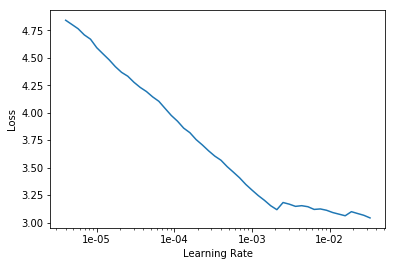

In [47]:
learn.recorder.plot(skip_start=20, skip_end=1)

In [48]:
lr = 3e-3

In [49]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.993852,0.839429,0.799748,01:48
1,0.710614,0.629271,0.847105,01:49
2,0.644460,0.519168,0.865430,01:48
3,0.644592,0.507889,0.863918,01:47
4,0.591754,0.500214,0.859317,01:46
5,0.563109,0.536766,0.866501,01:45
6,0.565269,0.497394,0.865201,01:45
7,0.517350,0.415749,0.875261,01:44
8,0.488699,0.374560,0.883212,01:44
9,0.410758,0.328324,0.900904,01:44


In [50]:
learn.save('stage-1')

In [51]:
learn.load('stage-1');

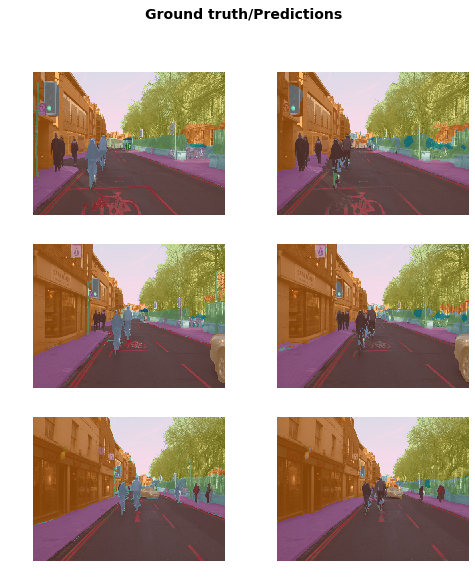

In [52]:
learn.show_results(rows=3, figsize=(8, 9))

In [55]:
learn.unfreeze()

In [57]:
lrs = slice(lr/400, lr/4)

In [58]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.375571,0.311039,0.902759,01:48
1,0.363369,0.302708,0.907050,01:50
2,0.352898,0.291446,0.912945,01:50
3,0.347124,0.292620,0.915692,01:50
4,0.342792,0.279530,0.922706,01:50
5,0.322903,0.301439,0.911352,01:50
6,0.331346,0.306795,0.914279,01:50
7,0.306625,0.299257,0.912631,01:50
8,0.318006,0.277625,0.919554,01:50
9,0.301013,0.301983,0.910320,01:50


In [59]:
learn.save('stage-2');

In [15]:
size = src_size

free = gpu_mem_get_free_no_cache()
bs = 3 if free > 8200 else 1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 7601MB of GPU RAM free


In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [22]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


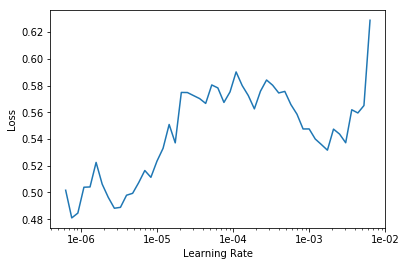

In [23]:
lr_find(learn)
learn.recorder.plot()


In [24]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))